For this you may need to downlad GPS data from Uni. Nevada Reno webpage. Uncomment those lines to avoid repeated download.

In [10]:
import urllib
import csv
import numpy as np
import pandas as pd
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LightSource
import scipy.io as sio
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
from mintpy.utils import readfile

/Users/bkv3/Documents/development/python/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)


Download and read GPS data

In [27]:
def read_data(sitename,time1,time2):
    filename='../GPS_data/'+sitename+'.txt'
    dfin = pd.read_csv(filename, header=0, delimiter=r"\s+")
    index = ['Time', 'East', 'North', 'Up']
    dataval= pd.DataFrame(index=index);dataerr=pd.DataFrame(index=index);
    dataval=pd.concat([dfin['yyyy.yyyy'].rename('time'), (dfin['_e0(m)']+dfin['__east(m)']).rename('east'), (dfin['____n0(m)']+dfin['_north(m)']).rename('north'), 
                    (dfin['u0(m)']+dfin['____up(m)']).rename('up')], axis=1)
    dataerr=pd.concat([dfin['yyyy.yyyy'].rename('time'), dfin['sig_e(m)'], dfin['sig_n(m)'], dfin['sig_u(m)']], axis=1, 
                 ignore_index=False)
    mask= (dataval['time'] > time1) & (dataval['time'] < time2)
    dataval=dataval[mask];dataerr=dataerr[mask];
    dataval['up']=dataval['up']*1000;dataval['east']=dataval['east']*1000;dataval['north']=dataval['north']*1000
    regr = linear_model.LinearRegression()
    regr.fit(dataval['time'].values.reshape(-1,1),dataval['east'].values.reshape(-1,1));east_vel=regr.coef_;
    regr.fit(dataval['time'].values.reshape(-1,1),dataval['north'].values.reshape(-1,1));north_vel=regr.coef_;
    return east_vel, north_vel;
def get_basemap(dem_file):
    dem, atr_dem = readfile.read(dem_file)
    geo_box=[]; 
    geo_box.append(np.float(atr_dem['X_FIRST']));geo_box.append(np.float(atr_dem['Y_FIRST']));
    geo_box.append(geo_box[0]+np.int(atr_dem['WIDTH'])*np.float(atr_dem['X_STEP']));
    geo_box.append(geo_box[1]+np.int(atr_dem['FILE_LENGTH'])*np.float(atr_dem['Y_STEP']));
    map_projection='cyl'; ls = LightSource(azdeg=315, altdeg=45)
    dem_shade = ls.shade(dem, vert_exag=1.0, cmap=plt.cm.gray, vmin=-20000, vmax=np.nanmax(dem)+2500)
    return dem_shade,geo_box

#DEM
dem_file='../InSAR_data/demGeo.h5'
dem_shade,geo_box=get_basemap(dem_file)
#Faults and coast lines
lines=sio.loadmat('../InSAR_data/hawaii_lines_new.mat',squeeze_me=True);
#GPS station details
gps_file ='../InSAR_data/GPS_station_list.txt'
gps_list = pd.read_csv(gps_file, header=0, delimiter=r"\s+")

#Download GPS data
for site in gps_list['Site']:
    link='http://geodesy.unr.edu/gps_timeseries/tenv3/IGS14/'+site+'.tenv3'
    outname= '../GPS_data/'+site+'.txt'
    urllib.request.urlretrieve(link,outname)
    
print('Finishied downloading GPS data')

Finishied downloading GPS data


Plot Figure

/Users/bkv3/Documents/development/python/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # Remove the CWD from sys.path while we load stuff.


[None, None, None, None]

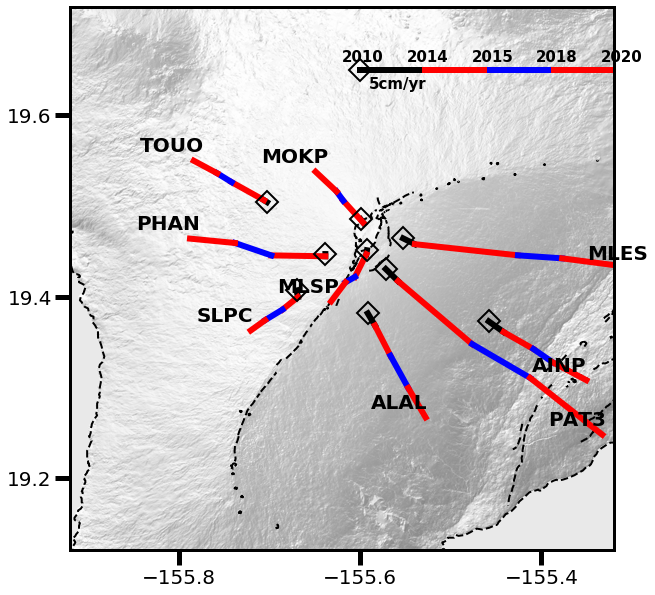

In [28]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111);ax.tick_params(labelsize=20);
ax.tick_params(axis='x',length=15, width=5); ax.tick_params(axis='y',length=15, width=5); 

#plot DEM in background
map_projection='cyl';
m = Basemap(llcrnrlon=geo_box[0], llcrnrlat=geo_box[3],\
            urcrnrlon=geo_box[2], urcrnrlat=geo_box[1],\
            projection= map_projection,\
            resolution='c', area_thresh=1., suppress_ticks=False, ax=ax)
m.imshow(dem_shade, origin='upper', interpolation='spline16')

#plot coast and faults
ax.plot(lines['Lllh'][:,0],lines['Lllh'][:,1],color='black', linestyle='dashed',linewidth=2)

#plot velcoity vectors between for different times for few stations in plot_lost
plot_list=['PAT3','ALAL','PHAN','SLPC','AINP','TOUO','MLES','MLSP','MOKP'];
times=[2010,2014.0862,2015.6632,2018.3265,2020.4086];
colors=['black','red','blue','red']

for i in range(len(gps_list)):
    if gps_list['Site'][i] in plot_list:
        X,Y,U,V=[],[],[],[];t=0.15; #factor to exaggerate the variation
        X.append(float(gps_list['lon'][i])),Y.append(float(gps_list['lat'][i]))
        for j in range(len(times)-1):
            u,v=read_data(gps_list['Site'][i],times[j],times[j+1]);u_ref,v_ref=read_data('MKEA',times[j],times[j+1]);
            u=u-u_ref;v=v-v_ref;#print gpslist[i],u,v
            ax.plot([X[j],X[j]+u/105*t],[Y[j],Y[j]+v/111*t],color=colors[j],linewidth=6)
            X.append(float(X[j]+u/105*t));Y.append(float(Y[j]+v/111*t));
        plt.plot(X[0],Y[0],'D',markersize=15,markerfacecolor='none', markeredgecolor='black',markeredgewidth=2.0)
        plt.text(X[-1]-0.06,Y[-1]+0.01,gps_list['Site'][i],fontsize=20,fontweight='bold') 
        

#plot index on top left with horizontal vectors
line_origin=float(-155.6)
U=[50.0,100.0,150.0,200.0]
X=[line_origin,float(line_origin+U[0]/105*t1),float(line_origin+U[1]/105*t1),float(line_origin+U[2]/105*t1),float(line_origin+U[3]/105*t1)];
Y=[19.65,19.65,19.65,19.65,19.65];
plt.plot(X[0],Y[0],'D',markersize=15,markerfacecolor='none', markeredgecolor='black',markeredgewidth=2.0)
for j in range(len(X)-1):
    ax.plot([X[j],X[j+1]],[Y[j],Y[j+1]],'-*',color=colors[j],linewidth=6)
    
n2=0.01;n1=0.02
plt.text(X[0]-n1,Y[0]+n2,'2010',fontsize=15,fontweight='bold');plt.text(X[1]-n1,Y[1]+n,'2014',fontsize=15,fontweight='bold');
plt.text(X[2]-n1,Y[2]+n2,'2015',fontsize=15,fontweight='bold');plt.text(X[3]-n1,Y[3]+n,'2018',fontsize=15,fontweight='bold');
plt.text(X[4]-n1,Y[4]+n2,'2020',fontsize=15,fontweight='bold');
plt.text(X[0]+n2,Y[0]-n1,'5cm/yr',fontsize=15,fontweight='bold');

#customize plot
ax.set_ylim((19.12,19.72));ax.set_xlim((-155.92,-155.32))
ax.set_xticks([-155.8,-155.6,-155.4]);ax.set_yticks([19.2,19.4,19.6])
plt.setp(ax.spines.values(), linewidth=3)

#savefig
#plt.savefig('Fig.1b_GPS_velocity_vecotrs.pdf',dpi=300,bbox_inches='tight',transparent=True)  